In [20]:
import pandas as pd
import numpy as np

In [63]:
import skimage
import sklearn
import matplotlib.pyplot as plt

In [112]:
import cv2
import os
import PIL

In [21]:
import mmselfsup
from mmselfsup.datasets import RelativeLocDataset
from mmselfsup.models import RelativeLoc

In [161]:
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, RandomCrop, RandomGrayscale, RandomHorizontalFlip, GaussianBlur

In [159]:
# set torch seed for reproducibility when using random image augmentations
torch.manual_seed(0)

## Helper Functions

In [260]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def image_to_patches(img):
    """Crop split_per_side x split_per_side patches from input image.
    Args:
        img (PIL Image): input image.
    Returns:
        list[PIL Image]: A list of cropped patches.
    """
    splits_per_side = 3  # split of patches per image side
    h, w = img.size()[1:]
    h_grid = h // splits_per_side
    w_grid = w // splits_per_side
    
    patches = [
        TF.crop(img, i * h_grid, j * w_grid, h_grid, w_grid)
        for i in range(splits_per_side) 
        for j in range(splits_per_side)
    ]
    
    return patches

## Load Data

In [144]:
tiny_imagenet = load_images_from_folder("./data/tiny-imagenet")
tiny_imagenet = [convert_to_PIL(img) for img in tiny_imagenet]

## Data Classes

In [266]:
# transform that will be applied to every raw image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# random augmentations
aug_transforms = [
    RandomCrop(50),
    RandomGrayscale(p=0.5),
    RandomHorizontalFlip(p=0.5),
    GaussianBlur(kernel_size=11, sigma=(0.1, 0.2))
]

In [267]:
class OriginalPatchLocalizationDataset(torch.utils.data.Dataset):
    """Dataset for relative patch location.
    The dataset crops image into several patches and concatenates every
    surrounding patch with center one. Finally it also outputs corresponding
    labels `0, 1, 2, 3, 4, 5, 6, 7`.
    """

    def __init__(self, data_source, transform=None):
        
        self.data_source = data_source
        self.transform = transform if transform else transforms.ToTensor()
        
    def __len__(self):
        # 8 samples per image
        # TODO: adjust this
        return 8*len(self.data_source)

    def __getitem__(self, idx):
        img = self.data_source[idx]
        
        img = self.transform(img)
        
        patches = image_to_patches(img)
        
        perms = self.generate_perms(patches)
        
        # create corresponding labels for patch pairs
        patch_labels = torch.LongTensor(list(range(8)))
                                        
        samples = (torch.stack(perms), patch_labels)
        return samples
    
    
    @staticmethod
    def generate_perms(patches):
        return [torch.cat((patches[4], patches[i]), dim=0) for i in range(9) if i != 4]

In [268]:
class OurPatchLocalizationDataset(OriginalPatchLocalizationDataset):
    """Dataset for relative patch location.
    The dataset crops image into several patches and concatenates every
    surrounding patch with center one. Finally it also outputs corresponding
    labels `0, 1, 2, 3, 4, 5, 6, 7`.
    """

    def __init__(self, data_source, transform=None, aug_transforms=None, seed=0):
        super(OurPatchLocalizationDataset, self).__init__(data_source, transform)
        
        self.seed = seed
        self.aug_transform = Compose(aug_transforms)
    
    @staticmethod
    def generate_perms(patches):
        # randomly transform outer patch in two different ways
        return [torch.cat((patches[4], self.aug_transform(patches[i]), self.aug_transform(patches[i])), dim=0) for i in range(9) if i != 4]

In [269]:
ds = OriginalPatchLocalizationDataset(tiny_imagenet, transform=transform)

In [270]:
ds[0]

(tensor([[[[-1.7754, -1.9809, -1.6384,  ..., -2.0323, -1.7583, -1.6555],
           [-1.9124, -1.8610, -1.9467,  ..., -2.1179, -2.1179, -1.9809],
           [-1.7925, -1.6555, -1.7412,  ..., -2.1179, -1.6213, -2.1179],
           ...,
           [-1.6213, -1.3302, -1.6384,  ..., -2.1179, -1.2103, -1.8610],
           [-1.5357, -1.3987, -1.2445,  ..., -2.1179, -1.4158, -0.1314],
           [-1.0048, -1.1418, -1.3302,  ..., -1.1932, -2.1179, -0.4739]],
 
          [[-1.0203, -1.3529, -1.0903,  ..., -0.9153, -0.5826, -0.4776],
           [-1.1779, -1.2304, -1.4405,  ..., -1.2654, -1.4405, -0.8452],
           [-1.0553, -1.0378, -1.1954,  ..., -1.2479, -0.4426, -1.3354],
           ...,
           [-1.6155, -1.2829, -1.4930,  ...,  1.8683,  2.2010,  0.8354],
           [-1.5980, -1.4230, -1.1604,  ...,  0.1352,  1.5882,  2.4286],
           [-1.0203, -1.1429, -1.2479,  ...,  1.6408,  0.3978,  2.2010]],
 
          [[-1.1073, -1.3861, -1.1073,  ..., -0.9330, -0.4624, -0.2532],
           [-

In [242]:
ds_loader = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, num_workers=2)

In [241]:
for X, y in ds_loader:
    print(X.shape)
    print(y)
    break

torch.Size([1, 8, 6, 21, 21])
tensor([[0, 1, 2, 3, 4, 5, 6, 7]])


In [236]:
i = TF.resize(tiny_imagenet[0], 224)

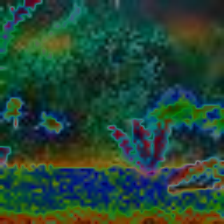

In [233]:
TF.solarize(i, 130)